<p style="text-align:center">
    <a href="https://skills.network" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo">
    </a>
</p>


# LoRA with PyTorch

Estimated time needed: **60** minutes

As an AI engineer, you are tasked with fine-tuning a model for sentiment analysis on the IMDB dataset, starting with a model that is pretrained on the AG News dataset. By leveraging Low-Rank Adaptation (LoRA), the model is initially trained on AG News, benefiting from its extensive labeled data and broad categorization capabilities. This robust foundation enhances the model’s language understanding.

Subsequently, LoRA is used to fine-tune the model on the IMDB dataset, adapting its knowledge to the nuances of movie reviews for sentiment analysis. This two-phase process — starting with AG News and refining with IMDB data — ensures that the model is both well-rounded and specialized, achieving superior performance in sentiment analysis tasks.

**Note: If you are already familiar with training a model on the IMDB dataset, you can run the cells and then jump to the Low-Rank Adaptation (LoRA) section**






![Documents Overload](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-GPXX0Y15EN/docs.png)

```Efficiency in parameter updates:``` LoRA introduces only a small fraction of additional parameters compared to the total number of parameters in a large model. This makes the training process faster and less resource-intensive because fewer parameters need to be updated during backpropagation.

```Preservation of pretrained knowledge:``` By keeping the majority of the model's weights fixed and only adjusting them through low-rank matrices, LoRA helps preserve the rich representations that the model learned during pretraining. This is particularly beneficial for tasks that do not require drastic deviations from the behavior learned during pretraining.

```Customization to specific tasks:``` Despite the minimal updates, the changes introduced by LoRA are significant enough to adapt the model to specific tasks. This lets you fine-tune large models on specialized tasks without the need for extensive retraining.

```Reduction in overfitting:``` Because only a limited number of parameters are adapted, the risk of overfitting is lower compared to full model fine-tuning, especially when adapting to smaller datasets.

```Scalability:``` LoRA scales well with model size. As models become larger, the relative increase in the number of parameters introduced by LoRA becomes even smaller, making it a particularly attractive option for adapting very large models.

```Compatibility and simplicity:``` The method can be easily applied to different types of neural networks, especially those based on the transformer architecture. It doesn't require major changes to the existing architecture, which simplifies integration into existing pipelines.


# __Table of Contents__

<ol>
    <li><a href="#Objectives">Objectives</a></li>
    <li>
        <a href="#Setup">Setup</a>
        <ol>
            <li><a href="#Install-required-libraries">Install required libraries</a></li>
            <li><a href="#Import-required-libraries">Import required libraries</a></li>
            <li><a href="#Defining-helper-functions">Defining helper functions</a></li>
        </ol>
    </li>
    <li>
        <a href="#Data-pipeline">Data pipeline</a>
        <ol>
            <li><a href="#Tokenizer">Tokenizer</a></li>
        </ol>
    </li>
    <li>
        <a href="#IMDB-dataset">IMDB dataset</a></li>
        <ol>
            <li><a href="#Dataset-composition">Dataset composition</a></li>
            <li><a href="#Applications">Applications</a></li>
            <li><a href="#Challenges">Challenges</a></li>
            <li><a href="#Train-and-validate">Train and validate</a></li>
            <li><a href="#Data-loader">Data loader</a></li>
            <li><a href="#Neural-network">Neural network</a></li>
        </ol>
     </li>
    <li>
        <a href="#Train-the-model-on-the-full-dataset">Train the model on the full dataset</a></li>
        <ol>
            <li><a href="#Train-the-model">Train the model</a></li>
        </ol>
     </li>
    <li>
        <a href="#Low-Rank-Adaptation-(LoRA)">Low-Rank Adaptation (LoRA)</a></li>
        <ol>
            <li><a href="#LoRA">LoRA</a></li>
            <li><a href="#Rank">Rank</a></li>
            <li><a href="#Understanding-LoRA-in-PyTorch">Understanding LoRA in PyTorch</a></li>
            <li><a href="#Applying-LoRA">Applying LoRA</a></li>
            <li><a href="#Loading-the-model">Loading the model</a></li>
        </ol>
     </li>
    <li>
        <a href="#Exercise:-Apply-LoRA-to-a-different-network">Exercise: Apply LoRA to a different network</a>
    </li>
</ol>


---


## Objectives

After completing this lab you are able to:

- Construct and train a neural network from the ground up
- Fine-tune a neural network in the conventional manner by unfreezing specific layers
- Use LoRA to fine-tune a neural network
- Comprehend the functions of LoRA and the reasons behind its effectiveness
- Save and load models that employ LoRA efficiently


---


## Setup


### Install required libraries


The following required libraries are __not__ preinstalled in the Skills Network Labs environment. __You must run the following cell__ to install them. Note that it can take between __5 and 10 minutes__ to install the required libraries:


In [84]:
!pip install torch==2.2.2
!pip install torchtext==0.17.2
!pip install portalocker==2.8.2
!pip install torchdata==0.7.1
!pip install plotly==5.22.0
!pip install pandas
!pip install matplotlib==3.9.0 scikit-learn==1.5.0

In [85]:
!pip install numpy==1.26.0

### Import required libraries

The following imports the required libraries:


In [86]:
from tqdm import tqdm
import numpy as np
import pandas as pd
from itertools import accumulate
import matplotlib.pyplot as plt
import math
import os

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchtext#; torchtext.disable_torchtext_deprecation_warning()
from torchtext.vocab import build_vocab_from_iterator, GloVe, Vectors



from sklearn.manifold import TSNE



from torch.utils.data import DataLoader
import numpy as np
from torchtext.datasets import AG_NEWS
from IPython.display import Markdown as md
from tqdm import tqdm

from torchtext.vocab import build_vocab_from_iterator

from torch.utils.data.dataset import random_split,Dataset
from torchtext.data.functional import to_map_style_dataset
from sklearn.manifold import TSNE
import plotly.graph_objs as go

import pickle

from urllib.request import urlopen
import io

import tarfile
import tempfile

# You can also use this section to suppress warnings generated by your code:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

### Defining helper functions

The following are some helper functions to help with plotting, saving, and loading files. These functions are not the main focus of this lab, you do not have to dwell on these too long. However, do run the cells in this section to define these helper functions:


In [87]:
def plot(COST,ACC):
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.plot(COST, color=color)
    ax1.set_xlabel('epoch', color=color)
    ax1.set_ylabel('total loss', color=color)
    ax1.tick_params(axis='y', color=color)

    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('accuracy', color=color)  # You already handled the x-label with ax1
    ax2.plot(ACC, color=color)
    ax2.tick_params(axis='y', color=color)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped

    plt.show()

In [88]:
import pickle

def save_list_to_file(lst, filename):
    """
    Save a list to a file using pickle serialization.

    Parameters:
        lst (list): The list to be saved.
        filename (str): The name of the file to save the list to.

    Returns:
        None
    """
    with open(filename, 'wb') as file:
        pickle.dump(lst, file)

def load_list_from_file(filename):
    """
    Load a list from a file using pickle deserialization.

    Parameters:
        filename (str): The name of the file to load the list from.

    Returns:
        list: The loaded list.
    """
    with open(filename, 'rb') as file:
        loaded_list = pickle.load(file)
    return loaded_list

---


## Data pipeline


### Tokenizer


A tokenizer takes as input a document and breaks it up into individual tokens. Now, you might wonder, what's a token?
This example might help you understand it better.

Imagine a token as a puzzle piece of a jigsaw puzzle. Each word, number, or small part of a word is a token. When you tokenize a document, you break it into these puzzle pieces so that a computer can understand and work with the text more easily, just like how you solve a puzzle by arranging its pieces.


First, import the **```get_tokenizer```** function from **```torchtext.data.utils```**.


In [89]:
from torchtext.data.utils import get_tokenizer

Next, we'll create the tokenizer. We'll set it to the "basic_english" tokenizer that is provided by `torchtext`. The "basic_english" tokenizer is designed to handle basic English text and splits the text into individual tokens based on spaces and punctuation marks.


In [90]:
tokenizer = get_tokenizer("basic_english")

Our dataset is going to be an iterable. Therefore, We'll use a generator function **```yield_tokens```** to apply **```tokenizer```**. The purpose of the generator function **```yield_tokens```** is to yield tokenized texts one at a time. Instead of processing the entire dataset and returning all of the tokenized texts in one go, the generator function processes and yields each tokenized text individually as it is requested. The tokenization process is performed lazily, which means the next tokenized text is generated only when needed, saving memory and computational resources.


In [91]:
def yield_tokens(data_iter):
    for  _,text in data_iter:
        yield tokenizer(text)

The following loads a pretrained word embedding model called GloVe into a variable called `glove_embedding`:


In [92]:
# Note that GloVe embeddings are typically downloaded using:
#glove_embedding = GloVe(name="6B", dim=100)
# However, the GloVe server is frequently down. The code below offers a workaround


class GloVe_override(Vectors):
    url = {
        "6B": "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/tQdezXocAJMBMPfUJx_iUg/glove-6B.zip",
    }

    def __init__(self, name="6B", dim=100, **kwargs) -> None:
        url = self.url[name]
        name = "glove.{}.{}d.txt".format(name, str(dim))
        #name = "glove.{}/glove.{}.{}d.txt".format(name, name, str(dim))
        super(GloVe_override, self).__init__(name, url=url, **kwargs)

class GloVe_override2(Vectors):
    url = {
        "6B": "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/tQdezXocAJMBMPfUJx_iUg/glove-6B.zip",
    }

    def __init__(self, name="6B", dim=100, **kwargs) -> None:
        url = self.url[name]
        #name = "glove.{}.{}d.txt".format(name, str(dim))
        name = "glove.{}/glove.{}.{}d.txt".format(name, name, str(dim))
        super(GloVe_override2, self).__init__(name, url=url, **kwargs)

try:
    glove_embedding = GloVe_override(name="6B", dim=100)
except:
    try:
        glove_embedding = GloVe_override2(name="6B", dim=100)
    except:
        glove_embedding = GloVe(name="6B", dim=100)

The following builds a vocabulary object from a pretrained GloVe word embedding model and sets the default index to the <unk> token:


In [93]:

from torchtext.vocab import vocab
vocab = vocab(glove_embedding .stoi, 0,specials=('<unk>', '<pad>'))
vocab.set_default_index(vocab["<unk>"])



The following prepares the text processing pipeline with the tokenizer and vocabulary. The text pipeline will be used to process the raw data strings from the dataset iterators.

The function **```text_pipeline```** first tokenizes the input text, following which **```vocab```** is applied to get the token indices.

The function **```label_pipeline```** simply converts labels into their integer values.


In [94]:
def text_pipeline(x):
  return vocab(tokenizer(x))

def label_pipeline(x):
   return int(x) 

---


## IMDB dataset 


The following loads the IMDB dataset into a temporary folder. This might take some time, so please be patient.


In [95]:
urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/35t-FeC-2uN1ozOwPs7wFg.gz')
tar = tarfile.open(fileobj=io.BytesIO(urlopened.read()))
tempdir = tempfile.TemporaryDirectory()
tar.extractall(tempdir.name)
tar.close()

The **IMDB dataset** contains movie reviews from the Internet Movie Database (IMDB) and is commonly used for binary sentiment classification tasks. It's a popular dataset for training and testing models in natural language processing (NLP), particularly in the context of sentiment analysis.

### Dataset composition

- **Reviews**: The dataset consists of 50,000 movie reviews, divided evenly into 25,000 training and 25,000 testing samples.
- **Sentiment labels**: Each review is labeled as either positive or negative, indicating the sentiment expressed in the review. The dataset is balanced, with an equal number of positive and negative reviews in both the training and testing sets.
- **Text content**: Reviews are presented as plain text and have been preprocessed to some extent. For example, HTML tags are removed, but the text retains its original punctuation and capitalization.
- **Usage**: The dataset is commonly used to train models for binary sentiment classification, where the goal is to predict whether a given review is positive or negative based on its text content.

### Applications

- **Sentiment analysis**: The primary application of the IMDB dataset is in sentiment analysis, where it serves as a benchmark for various text classification algorithms.
- **Natural language processing (NLP)**: The dataset is widely used in NLP research and applications, providing a basis for testing the effectiveness of different models and approaches in understanding human language.

### Challenges

The dataset is small, so it's hard to train a model from scratch.

The following class is defined to traverse the IMDB dataset. The need to define this class arises from the fact that the IMDB dataset is split across a large number of files:


In [96]:
class IMDBDataset(Dataset):
    def __init__(self, root_dir, train=True):
        """
        root_dir: The base directory of the IMDB dataset.
        train: A boolean flag indicating whether to use training or test data.
        """
        self.root_dir = os.path.join(root_dir, "train" if train else "test")
        self.neg_files = [os.path.join(self.root_dir, "neg", f) for f in os.listdir(os.path.join(self.root_dir, "neg")) if f.endswith('.txt')]
        self.pos_files = [os.path.join(self.root_dir, "pos", f) for f in os.listdir(os.path.join(self.root_dir, "pos")) if f.endswith('.txt')]
        self.files = self.neg_files + self.pos_files
        self.labels = [0] * len(self.neg_files) + [1] * len(self.pos_files)
        self.pos_inx=len(self.pos_files)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_path = self.files[idx]
        label = self.labels[idx]
        with open(file_path, 'r', encoding='utf-8') as file:
            content = file.read()
            
        return label, content

The following uses the `IMDBDataset` class defined above to create iterators for the train and test datasets:


In [97]:
root_dir = tempdir.name + '/' + 'imdb_dataset'
train_iter = IMDBDataset(root_dir=root_dir, train=True)  # For training data
test_iter = IMDBDataset(root_dir=root_dir, train=False)  # For test dataart=train_iter.pos_inx


The following prints 20 samples from the training set:


In [98]:

start=train_iter.pos_inx
start=0
for i in range(-10,10):
    print(train_iter[start+i])

(1, 'I rented this some years ago, the video store had only VHS at the time. Straight to video was hitting it\'s strides (you know, where the box covers use the same font and color schemes of successful films).I didn\'t know what to expect other than what was printed. First thing I thought while watching was "what the hells\' wrong with the sound?"-Obviously there was no dialogue dubbing. Words echoed, so I stopped munching on whatever I had to pay closer attention-mind you there\'s no Shakespeare here!,just simple talk. The story is simple enough, boy meets girl etc.. What struck me as humorous and heartfelt was, the people in the movie didn\'t seem like caricatures written into the story,but rather non-actors plucked temporarily from their real jobs(uniforms included). All the while, you begin to sense what the filmmaker is after,then see that there are no attempts at cheap humor(people hurting their privates,using vulgarities this couldn\'t have hurt the marketing. There was somethi

The following defines the mapping of numeric labels to positive and negative reviews:


In [99]:
imdb_label = {0: " negative review", 1: "positive review"}
imdb_label[1]

'positive review'

The following checks to make sure that there are exactly 2 classes in the train dataset:


In [100]:
num_class = len(set([label for (label, text) in train_iter ]))
num_class

The following are some token indices:


In [101]:
vocab(["age","hello"])

### Train and validate


The following converts the dataset into map-style datasets and then performs a random split to create separate training and validation datasets. The training dataset will contain 95% of the samples in the original training set, while the validation dataset will contain the remaining 5%. These datasets can be used for training and evaluating a machine learning model for text classification on the IMDB dataset. The final performance of the model will be evaluated on the hold-out test set:


In [102]:

# Convert the training and testing iterators to map-style datasets.
train_dataset = to_map_style_dataset(train_iter)
test_dataset = to_map_style_dataset(test_iter)

# Determine the number of samples to be used for training and validation (5% for validation).
num_train = int(len(train_dataset) * 0.95)

# Randomly split the training dataset into training and validation datasets using `random_split`.
# The training dataset will contain 95% of the samples, and the validation dataset will contain the remaining 5%.
split_train_, split_valid_ = random_split(train_dataset, [num_train, len(train_dataset) - num_train])

The following code checks if a CUDA-compatible GPU is available in the system using PyTorch, a popular deep learning framework. If a GPU is available, it assigns the device variable to "cuda" (which stands for CUDA, the parallel computing platform and application programming interface model developed by NVIDIA). If a GPU is not available, it assigns the device variable to "cpu" (which means the code will run on the CPU instead).


In [103]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

### Data loader


In PyTorch, the **`collate_fn`** function is used in conjunction with data loaders to customize the way batches are created from individual samples. The provided code defines a `collate_batch` function in PyTorch, which is used with data loaders to customize batch creation from individual samples. It processes a batch of data, including labels and text sequences. It applies the `text_pipeline` function to preprocess the text. The processed data is then converted into PyTorch tensors and returned as a tuple containing the label tensor, text tensor, and offsets tensor representing the starting positions of each text sequence in the combined tensor. The function also ensures that the returned tensors are moved to the specified device (e.g., GPU) for efficient computation.


In [104]:
from torch.nn.utils.rnn import pad_sequence

def collate_batch(batch):
    label_list, text_list = [], []
    for _label, _text in batch:
        label_list.append(label_pipeline(_label))
        text_list.append(torch.tensor(text_pipeline(_text), dtype=torch.int64))


    label_list = torch.tensor(label_list, dtype=torch.int64)
    text_list = pad_sequence(text_list, batch_first=True)


    return label_list.to(device), text_list.to(device)

You convert the dataset objects to a data loader by applying the collate function.


In [105]:
BATCH_SIZE = 64

train_dataloader = DataLoader(
    split_train_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
valid_dataloader = DataLoader(
    split_valid_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
test_dataloader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)

Let's check the what these data loaders generate:


In [106]:
label,seqence=next(iter(valid_dataloader ))
label,seqence

(tensor([0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0,
         1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1,
         1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1]),
 tensor([[  520,  9810,     6,  ...,     0,     0,     0],
         [   39,    16,     9,  ...,     0,     0,     0],
         [    2, 31680,   120,  ...,     0,     0,     0],
         ...,
         [   39,    16,     9,  ...,     0,     0,     0],
         [   43,   392,   205,  ...,     0,     0,     0],
         [   43,   457,    39,  ...,     0,     0,     0]]))

### Neural network


This code defines a class called `TextClassifier` that represents a simple text classifier that uses an embedding layer, a hidden linear layer with a ReLU avtivation, and an output linear layer. The constructor takes the following arguments:

- `num_class`: The number of classes to classify.
- `freeze`: Whether to freeze the embedding layer.


In [107]:
from torch import nn

class TextClassifier(nn.Module):
    def __init__(self, num_classes,freeze=False):
        super(TextClassifier, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(glove_embedding.vectors.to(device),freeze=freeze)
        # An example of adding additional layers: A linear layer and a ReLU activation
        self.fc1 = nn.Linear(in_features=100, out_features=128)
        self.relu = nn.ReLU()
        # The output layer that gives the final probabilities for the classes
        self.fc2 = nn.Linear(in_features=128, out_features=num_classes)

    def forward(self, x):
        # Pass the input through the embedding layer
        x = self.embedding(x)
        # Here you can use a simple mean pooling

        x = torch.mean(x, dim=1)
        # Pass the pooled embeddings through the additional layers
        x = self.fc1(x)
        x = self.relu(x)
        return self.fc2(x)






## Train the model on the full dataset

The model can then be trained on labeled data from the IMDB dataset with two classes.


First, let's create the model.


In [108]:
model=TextClassifier(num_classes=2,freeze=True)
model.to(device)

TextClassifier(
  (embedding): Embedding(400000, 100)
  (fc1): Linear(in_features=100, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

The code line `predicted_label=model(text, offsets)` is used to obtain predicted labels from a model for a given input text and its corresponding offsets.


In [109]:
model.eval()
predicted_label=model(seqence)

The following returns the shape of `predicted_label`. Because your dataset iterators are batching 64 inputs, `predicted_label` should return 64 rows:


In [110]:
print(predicted_label.shape)

torch.Size([64, 2])


For each input, the model outputs two logits corresponding to the two classes in the classification task. If the value of the first logit is greater than the second, the predicted class is class 0, which maps to a negative review. If the second logit is greater than the first, the predicted class is class 1, which maps to a positive review:


In [111]:
predicted_label

tensor([[-0.1612,  0.1260],
        [-0.0941,  0.0863],
        [-0.1724,  0.1257],
        [-0.1353,  0.1096],
        [-0.1685,  0.1266],
        [-0.1534,  0.1189],
        [-0.1592,  0.1262],
        [-0.1308,  0.1079],
        [-0.1577,  0.1253],
        [-0.0464,  0.0584],
        [-0.1808,  0.1330],
        [-0.1522,  0.1190],
        [-0.1691,  0.1244],
        [-0.0608,  0.0632],
        [-0.1236,  0.1068],
        [-0.1424,  0.1130],
        [-0.1206,  0.1014],
        [-0.1487,  0.1186],
        [-0.1492,  0.1232],
        [-0.1596,  0.1219],
        [-0.1682,  0.1311],
        [-0.1586,  0.1229],
        [-0.1002,  0.0980],
        [-0.1653,  0.1260],
        [-0.1694,  0.1270],
        [-0.1094,  0.0948],
        [-0.1379,  0.1162],
        [-0.1739,  0.1299],
        [-0.1769,  0.1294],
        [-0.1530,  0.1198],
        [-0.1595,  0.1241],
        [-0.1157,  0.1039],
        [-0.1692,  0.1258],
        [-0.1540,  0.1211],
        [-0.1516,  0.1196],
        [-0.0833,  0

The following **`predict`** function takes in a text, a text pipeline, and a model as inputs. It uses a pretrained model passed as a parameter to predict the label of the text for text classification on the IMDB dataset:


In [112]:
def predict(text, model, text_pipeline):
    with torch.no_grad():
        text = torch.unsqueeze(torch.tensor(text_pipeline(text)),0).to(device)

        output = model(text)
        return imdb_label[output.argmax(1).item()]

In [113]:
predict("the is a good movie",model,text_pipeline )

'positive review'

You can create a function to evaluate the model's accuracy on a dataset:


In [114]:
def evaluate(dataloader, model, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for label, text in dataloader:
            label, text = label.to(device), text.to(device)
            outputs = model(text)
            _, predicted = torch.max(outputs.data, 1)
            total += label.size(0)
            correct += (predicted == label).sum().item()
    accuracy = 100 * correct / total
    return accuracy

The following evaluates the performance of your model on the test set:


In [115]:
evaluate(test_dataloader , model, device)

Note that the current performance of the model is no better than average. This outcome is expected, considering that the model has not undergone any training yet.


## Train the model

The following defines the training function used to train the model:


In [116]:
def train_model(model, optimizer, criterion, train_dataloader, valid_dataloader, epochs=100, model_name="my_modeldrop"):
    cum_loss_list = []
    acc_epoch = []
    best_acc = 0
    file_name = model_name
    
    for epoch in tqdm(range(1, epochs + 1)):
        model.train()
        cum_loss = 0
        for _, (label, text) in enumerate(train_dataloader):            
            optimizer.zero_grad()
            predicted_label = model(text)
            loss = criterion(predicted_label, label)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
            optimizer.step()
            cum_loss += loss.item()
        #print("Loss:", cum_loss)
        cum_loss_list.append(cum_loss)
        acc_val = evaluate(valid_dataloader, model, device)
        acc_epoch.append(acc_val)
        
        if acc_val > best_acc:
            best_acc = acc_val
            print(f"New best accuracy: {acc_val:.4f}")
            #torch.save(model.state_dict(), f"{model_name}.pth")
    
    #save_list_to_file(cum_loss_list, f"{model_name}_loss.pkl")
    #save_list_to_file(acc_epoch, f"{model_name}_acc.pkl")


---


The following sets the learning rate (LR) to 1, which determines the step size at which the optimizer updates the model's parameters during training. The CrossEntropyLoss criterion is used to calculate the loss between the model's predicted outputs and the ground truth labels. This loss function is commonly employed for multi-class classification tasks.

The chosen optimizer is Stochastic Gradient Descent (SGD), which optimizes the model's parameters based on the computed gradients with respect to the loss function. The SGD optimizer uses the specified learning rate to control the size of the weight updates.

Additionally, a learning rate scheduler is defined using StepLR. This scheduler adjusts the learning rate during training, reducing it by a factor (gamma) of 0.1 after every epoch (step) to improve convergence and fine-tune the model's performance. These components together form the essential setup for training a neural network using the specified learning rate, loss criterion, optimizer, and learning rate scheduler.

For the sake of time efficiency, the number of epochs has been set to 2. This is to give you a practical demonstration of what the training process looks like. However, if you were to train this model in a real-world scenario, you would likely increase the number of epochs to a larger figure, such as 100 or more. Given the reduced training set defined earlier, it takes approximately 2 minutes to complete 2 epochs of training:


In [117]:
LR=1

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)

You have pretrained the model for 300 epochs using a GPU and saved this model for your convenience. However, to demonstrate the training process, the following code has been included that trains the model for just two epochs. Please note that you have limited the number of epochs to two because training on a CPU can be time-consuming. Even with just two epochs, you can expect the following code to run for approximately one minute.


In [118]:
model_name="model_imdb_freeze_true2"
train_model(model, optimizer, criterion, train_dataloader, valid_dataloader, epochs=2, model_name=model_name)

 50%|█████     | 1/2 [00:03<00:03,  3.41s/it]

New best accuracy: 50.6400


100%|██████████| 2/2 [00:06<00:00,  3.35s/it]


Instead of evaluating the model trained on 2 epochs, let's load the pretrained model that was trained for 300 epochs:


In [119]:

%%capture 
!wget https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/ZvhVWJU0flC7BmU1jjYxjg/model-imdb-freeze-true2.pth
!wget https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/2RdN-JG4Rm5Gx3UNtOP4NA/model-imdb-freeze-true2-acc.pkl
!wget https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/8qoGvWk0BdXRGoFAOT-dAw/model-imdb-freeze-true2-loss.pkl


Let's plot the cost and accuracy for each epoch for the pretrained model that was trained for 300 epochs. From the plot, it becomes evident that with just a few epochs, the accuracy exhibits significant volatility.


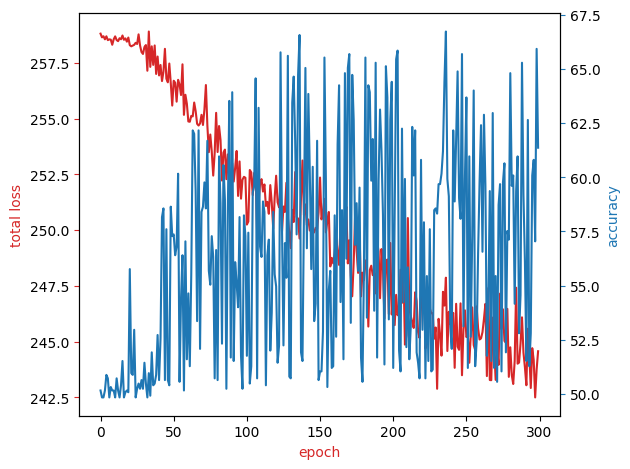

In [120]:
cum_loss_list=load_list_from_file(model_name.replace('_','-') + "-loss.pkl")
acc_epoch=load_list_from_file(model_name.replace('_','-') + "-acc.pkl")
plot(cum_loss_list,acc_epoch)

Here, you load the model that has been trained for you. Please comment out these lines if you want to train the model yourself.


In [121]:
model.load_state_dict(torch.load(model_name.replace('_','-') + ".pth", map_location=device))
model.eval()

TextClassifier(
  (embedding): Embedding(400000, 100)
  (fc1): Linear(in_features=100, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

The following evaluates the model on the test data. The pretrained model achieves an accuracy of 66%.


In [122]:
evaluate(test_dataloader , model, device)

##  Low-Rank Adaptation (LoRA)

PyTorch and the Hugging Face library provide robust tools for model manipulation with LoRA, but they are not intuitive. In this section, you delve into building a LoRA (Low-Rank Adaptation) implementation from scratch using PyTorch. LoRA is a general method, but it's commonly applied to the Attention layer. For the sake of simplicity, in this lab, you apply it to a Vanilla neural network. This decision is made because accessing the Attention Parameters in the PyTorch Encoder module can be challenging.


### LoRA
1) For any arbitrary layer of a network, you have the model with pretrained parameters $ W_0 $, which are the parameters of the model. If you only consider the attention parameters for each layer, at a minimum $ 4 \times m \times n$ for each layer. For many models, this can reach in the trillions of learnable parameters. Each time you fine-tune a new dataset, you have to store trillions of parameters.

2) $ \Delta W $ represents two matrices $ B $ and $ A $, where $ B $ and $ A $ are constrained such that $ B \in \mathbb{R}^{m \times r} $, $ A \in \mathbb{R}^{r \times n} $, and $ r \leq \min(m, n) $. The total number of parameters is $ A $ and $ B $ is much smaller than $ W_1$  and much easier to store.

$ W_1\approx W_0 + \Delta  W = W_0 + BA $



3) To train and predict, the forward pass holds $W_0$ constant.

$h = W_0 + \Delta W  = W_0x + BAx $





To scale $\Delta W \times \dfrac{\alpha'}{r}$, where $\alpha$ is a constant in $ r $.  Adjusting $\alpha'$ is similar to tuning the learning rate if the initialization is properly scaled. Therefore, you set $\alpha'$ to the first $ r $ you try and do not tune it further; just use $\alpha$. This scaling reduces the need to retune hyperparameters. The final form is:

$h =  W_0x +  \dfrac{\alpha'}{r} BAx=  W_0x +  \alpha BAx $

The following example illustrates the process.


$
W_0 + BA = 
\begin{bmatrix}
w_{11} & w_{12} & w_{13} & w_{14} \\\\\\\\\\\\\\\\\\\\\\
w_{21} & w_{22} & w_{23} & w_{24} \\\\\\
w_{31} & w_{32} & w_{33} & w_{34} \\\\\\
w_{41} & w_{42} & w_{43} & w_{44} \\\\\\
\end{bmatrix} +
\begin{bmatrix}
a_1 \\\\\\
a_2 \\\\\\
a_3 \\\\\\
a_4 \\\\\\
\end{bmatrix}
\begin{bmatrix}
b_1 & b_2 & b_3 & b_4 \\\\
\end{bmatrix}
$

This illustrates the product of matrices $ A $ and $ B $, denoted as $ AB $, which can be added to $ W_0 $. However, the resulting matrix $ W_0 + AB $ is limited depending on the dimensions of $ A $ and $ B $. This limitation is due to the concept of rank.



### Rank
The rank of a matrix is the number of dimensions the rows of the matrix "live in."  A square matrix is said to be **full rank** if its <a href='https://en.wikipedia.org/wiki/Rank_(linear_algebra)?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2022-01-01'>rank</a> is equal to the number of its rows or columns. Let's make this idea more intuitive with an example.


In [123]:
from sympy import Matrix, init_printing,Symbol
from numpy.linalg import qr,eig,inv,matrix_rank,inv, norm
from scipy.linalg import null_space
from sympy import Matrix, init_printing,Symbol
init_printing()

In [124]:
def plot_matrix_and_subspace(F):
    assert F.shape[0] == 3, "Matrix F must have rows equal to 3 for 3D visualization."
    
    ax = plt.figure().add_subplot(projection='3d')
    
    # Plot each column vector of F as a point and line from the origin
    for i in range(F.shape[1]):
        ax.quiver(0, 0, 0, F[0, i], F[1, i], F[2, i], color='blue', arrow_length_ratio=0.1, label=f'Column {i+1}')

    if F.shape[1] == 2:
        # Calculate the normal to the plane spanned by the columns of F if they are exactly two
        normal_vector = np.cross(F[:, 0], F[:, 1])
        # Plot the plane
        xx, yy = np.meshgrid(np.linspace(-3, 3, 10), np.linspace(-3, 3, 10))
        zz = (-normal_vector[0] * xx - normal_vector[1] * yy) / normal_vector[2] if normal_vector[2] != 0 else 0
        ax.plot_surface(xx, yy, zz, alpha=0.5, color='green', label='Spanned Plane')

    # Set plot limits and labels
    ax.set_xlim([-3, 3])
    ax.set_ylim([-3, 3])
    ax.set_zlim([-3, 3])
    ax.set_xlabel('$x_{1}$')
    ax.set_ylabel('$x_{2}$')
    ax.set_zlabel('$x_{3}$')
    #ax.legend()

    plt.show()

In [125]:
def plot_matrix_and_subspace(F):
    assert F.shape[0] == 3, "Matrix F must have 3 rows to represent 3D space."

    ax = plt.figure().add_subplot(projection='3d')
    
    # Plot each column vector of F
    for i in range(F.shape[1]):
        ax.quiver(0, 0, 0, F[0, i], F[1, i], F[2, i], color='blue', arrow_length_ratio=0.1, label=f'Column {i+1}')

    # Calculate the null space of the transpose of F
    normal_vector = null_space(F.T)
    
    # Check that the null space is 1-dimensional
    if normal_vector.shape[1] == 1:
        normal_vector = normal_vector[:, 0]  # Simplify the array to 1D
        # Create a meshgrid for the plane
        xx, yy = np.meshgrid(np.linspace(-3, 3, 10), np.linspace(-3, 3, 10))
        # Calculate corresponding z coordinates based on the plane equation ax + by + cz = 0
        zz = (-normal_vector[0] * xx - normal_vector[1] * yy) / normal_vector[2] if normal_vector[2] != 0 else 0
        ax.plot_surface(xx, yy, zz, alpha=0.5, color='green', label='Spanned Plane')
    else:
        print("The null space is not 1-dimensional, so a unique plane cannot be determined.")

    # Set plot limits and labels
    ax.set_xlim([-3, 3])
    ax.set_ylim([-3, 3])
    ax.set_zlim([-3, 3])
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    #ax.legend()

    plt.show()



In the context of Low-Rank Adaptation (LoRA), where $B \in \mathbb{R}^{d \times r}$, the matrix $B$:





In [126]:
B=torch.tensor([[1,0],[0,1],[0,0]]).numpy()

Matrix(B)


⎡1  0⎤
⎢    ⎥
⎢0  1⎥
⎢    ⎥
⎣0  0⎦

This $3 \times 2$ matrix has columns that span a 2-dimensional subspace in $\mathbb{R}^3$. Specifically, the columns of $B$ are:

- $\mathbf{b}_1 = \begin{bmatrix} 1 \\\\\\\\\\\\\\\\\\\\ 0 \\ 0 \end{bmatrix}$
- $\mathbf{b}_2 = \begin{bmatrix} 0 \\\\ 1 \\ 0 \end{bmatrix}$

These columns are standard basis vectors for the $xy$-plane in $\mathbb{R}^3$, and, thus, they span the $xy$-plane shown in green in the following image. Muliplying each column vector in blue by a scaler always falls in the plane.


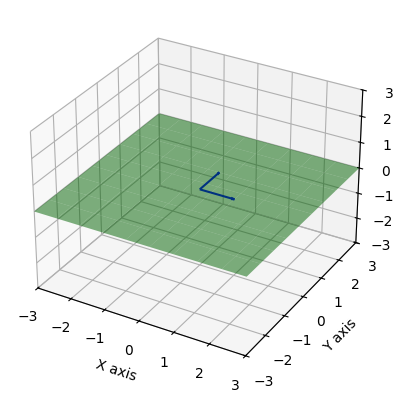

In [127]:
 plot_matrix_and_subspace(B)

In this scenario, the vectors, despite each having three components, can reach any point on the two-dimensional green plane depicted in the image. These vectors span the green plane, which resides within a two-dimensional subspace. This subspace's dimension, also known as its 'rank', is two—corresponding to the dimensionality of the plane. If the rank were three, any point in the 3D space could be reached by some combination of the columns of $𝐵$. The rank of a matrix can be determined by using the matrix_rank function provided by NumPy.


In [128]:
matrix_rank(B)

2

Here, you plot a different matrix where the matrix spans a different plane, but the rank remains two.


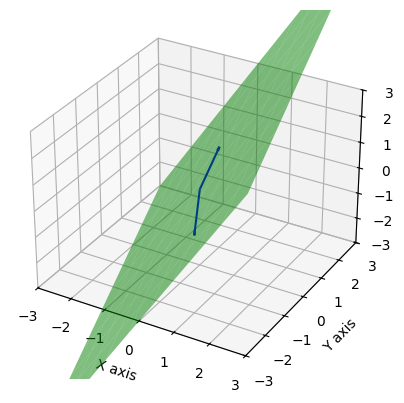

rank of B 2


In [129]:
B_=torch.tensor([[1,0],[-2,1],[0,1]]).numpy()
plot_matrix_and_subspace(B_)
print("rank of B",matrix_rank(B_))

In [130]:
matrix_rank(B)

2

Here, you present the matrix ```A```. The rank of this matrix is also two.


In [131]:
A=torch.tensor([[1,1,-1,1,0],[-2,2,2,0,1]]).numpy()
Matrix(A)


⎡1   1  -1  1  0⎤
⎢               ⎥
⎣-2  2  2   0  1⎦

In [132]:
matrix_rank(A)

2

For the matrices $ C = BA $, if $B $ and $ A $ both have a rank of $ r $:


In [133]:
C=B@A
Matrix(C)


⎡1   1  -1  1  0⎤
⎢               ⎥
⎢-2  2  2   0  1⎥
⎢               ⎥
⎣0   0  0   0  0⎦

 The columns of $ C $ will have the same rank as $ B $. Furthermore, the span of the columns of $ C $ will be the same as the span of the columns of $ B $.


rank of C 2


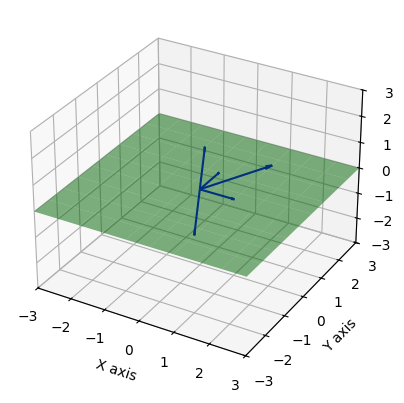

In [134]:
print("rank of C",matrix_rank(C))
plot_matrix_and_subspace(C)

### Understanding LoRA in PyTorch

LoRA (Low-Rank Adaptation) is relatively simple to initialize in PyTorch. You initialize LoRA with the dimensions of the input (`in_dim`), $ m $, output (`out_dim`), $n $, a rank (`rank`), $ r $, and a scaling factor `alpha`. The parameters are initialized as follows:

```
self.A = torch.nn.Parameter(torch.randn(in_dim, rank) * std_dev)
self.B = torch.nn.Parameter(torch.zeros(rank, out_dim))
```

The use of  ```nn.Parameter``` makes these values learnable parameters.

In the forward function, LoRA uses the notation $BAx$ PyTorch, the input vector is a row, so the output becomes $x^TA^TB^T$ will drop the trapose from now on. The forward pass is implemented as:
```
x = self.alpha * (x @ self.A @ self.B)
```
The use of  ```nn.Parameter``` makes these values learnable parameters.



In [135]:
class LoRALayer(torch.nn.Module):
    def __init__(self, in_dim, out_dim, rank, alpha):
        super().__init__()
        std_dev = 1 / torch.sqrt(torch.tensor(rank).float())
        self.A = torch.nn.Parameter(torch.randn(in_dim, rank) * std_dev)
        
        self.B = torch.nn.Parameter(torch.zeros(rank, out_dim))
        self.alpha = alpha

    def forward(self, x):
        x = self.alpha * (x @ self.A @ self.B)
        return x

This class ```LinearWithLoRA```  copies the original linear model and creates a ```LoRALayer``` object. 
```
self.linear = linear.to(device)
 self.lora = LoRALayer(
            linear.in_features, linear.out_features, rank, alpha
        ).to(device)
```

Then, in the forward method apply both the original linear model and the output Lora model to the input x and add them together ```self.linear(x) + self.lora(x)```. This corresponds to:

 $xW_0 + xAB $


In [136]:
class LinearWithLoRA(torch.nn.Module):
    def __init__(self, linear, rank, alpha):
        super().__init__()
        self.linear = linear.to(device)
        self.lora = LoRALayer(
            linear.in_features, linear.out_features, rank, alpha
        ).to(device)

    def forward(self, x):
        
        return self.linear(x) + self.lora(x)

### Applying LoRA
To fine-tune with LoRA, first, load a pretrained TextClassifier model with LoRA (while freezing its layers), load its pretrained state from a file, and then disable gradient updates for all of its parameters to prevent further training. Here, you will load a model that was pretrained on the AG NEWS dataset, which is a dataset that has 4 classes. Note that when you initialize this model, you set `num_classes` to 4. Moreover, the pretrained AG_News model was trained with the embedding layer unfrozen. Hence you will initialize the model with `freeze=False`. Although you are initializing the model with layers unfrozen and the wrong number of classes for your task, you will make modifications to the model later on that correct this:


In [137]:
from urllib.request import urlopen
import io

model_lora=TextClassifier(num_classes=4,freeze=False)
model_lora.to(device)

urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/uGC04Pom651hQs1XrZ0NsQ/my-model-freeze-false.pth')

stream = io.BytesIO(urlopened.read())
state_dict = torch.load(stream, map_location=device)
model_lora.load_state_dict(state_dict)

# Here, you freeze all layers:
for parm in model_lora.parameters():
    parm.requires_grad=False
model_lora

TextClassifier(
  (embedding): Embedding(400000, 100)
  (fc1): Linear(in_features=100, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=4, bias=True)
)

Note that the `for` loop in the above code froze all of the layers in the neural network, including the embedding layer.


Additionally, note that the original model was on a classification problem that had four classes, while the IMDB dataset has just 2 classes. To account for this, you will replace the final layer with a new linear layer where the number of outputs equals 2:


In [138]:
model_lora.fc2=nn.Linear(in_features=128, out_features=2, bias=True).to(device)
model_lora

TextClassifier(
  (embedding): Embedding(400000, 100)
  (fc1): Linear(in_features=100, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

Let's view all of the modules in the object.


In [139]:
model_lora

TextClassifier(
  (embedding): Embedding(400000, 100)
  (fc1): Linear(in_features=100, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

Your task now is to replace the hidden layer with a LoRA layer. You can access the hidden layer as follows:


In [140]:
model_lora.fc1

Linear(in_features=100, out_features=128, bias=True)

The following replaces this layer with a LoRA layer:


In [141]:
model_lora.fc1=LinearWithLoRA(model_lora.fc1,rank=2, alpha=0.1).to(device)

Let's look at the hidden layer again to ensure that it is indeed converted to a LoRA layer.


In [142]:
model_lora.fc1

LinearWithLoRA(
  (linear): Linear(in_features=100, out_features=128, bias=True)
  (lora): LoRALayer()
)

At this point, training the model is similar, with the only difference being that, except for the output layer, only the learnable parameters 
```A``` and  ```B``` will be updated. The code to select the values for  `r` and `alpha`, which is not run, is nonetheless provided herein for your convenience.


In [143]:
model_lora.to(device)

TextClassifier(
  (embedding): Embedding(400000, 100)
  (fc1): LinearWithLoRA(
    (linear): Linear(in_features=100, out_features=128, bias=True)
    (lora): LoRALayer()
  )
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

<details>
<summary><b>Click here to see code to select r and alpha</b></summary>
    
```python 
ranks = [1, 2, 5, 10]
alphas = [0.1, 0.5, 1.0, 2.0, 5.0]

results=[]
accuracy_old=0
# Loop over each combination of 'r' and 'alpha'
for r in ranks:
    for alpha in alphas:
        print(f"Testing with rank = {r} and alpha = {alpha}")
        model_name=f"model_lora_rank{r}_alpha{alpha}_AGtoIBDM_final_adam_"
        
        model_lora=TextClassifier(num_classes=4,freeze=False)
        model_lora.to(device)
        
        urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/uGC04Pom651hQs1XrZ0NsQ/my-model-freeze-false.pth')
        
        stream = io.BytesIO(urlopened.read())
        state_dict = torch.load(stream, map_location=device)
        model_lora.load_state_dict(state_dict)
        
        for parm in model_lora.parameters():
            parm.requires_grad=False
        
        model_lora.fc2=nn.Linear(in_features=128, out_features=2, bias=True)
        model_lora.fc1=LinearWithLoRA(model_lora.fc1,rank=r, alpha=alpha )
        optimizer = torch.optim.Adam(model_lora.parameters(), lr=LR)

        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1)
        
        model_lora.to(device)
        
        
        

        
        train_model(model_lora, optimizer, criterion, train_dataloader, valid_dataloader, epochs=300, model_name=model_name)
        
        accuracy=evaluate(valid_dataloader ,  model_lora, device)
        result = {
            'rank': r,
            'alpha': alpha,
            'accuracy':accuracy
        }

        # Append the dictionary to the results list
        results.append(result)
        
        
        
        

        if accuracy>accuracy_old:
            print(f"Testing with rank = {r} and alpha = {alpha}")
            print(f"accuracy: {accuracy} accuracy_old: {accuracy_old}" )
            accuracy_old=accuracy
            torch.save(model.state_dict(), f"{model_name}.pth")
            save_list_to_file(cum_loss_list, f"{model_name}_loss.pkl")
            save_list_to_file(acc_epoch, f"{model_name}_acc.pkl")
            
        
```       



Let's set up the training components for the `model_lora` model, defining a learning rate of 1, using cross-entropy loss as the criterion, optimizing with stochastic gradient descent (SGD), and scheduling the learning rate to decay by a factor of 0.1 at each epoch:


In [144]:
LR=1
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_lora.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)


You have pretrained a model using an identical procedure for 300 epochs and saved it for your convenience. However, to give you a taste of how training works in practice, run the following code to train the model for just 2 epochs.


In [145]:
model_name="model_lora_final2"
train_model(model_lora,optimizer, criterion, train_dataloader, valid_dataloader, epochs=2, model_name=model_name)


 50%|█████     | 1/2 [00:03<00:03,  3.04s/it]

New best accuracy: 55.8400


100%|██████████| 2/2 [00:06<00:00,  3.04s/it]


Instead of evaluating the model you just trained for 2 epochs, lets have a look at the LoRA model pretrained on 300 epochs:


In [146]:

%%capture 
!wget https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/JWPRb1RMhKLRMUWOKw9pxA/model-lora-final2.pth
!wget https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/_dm02rLyTrwsXEQh2r32sQ/model-lora-final2-acc.pkl
!wget https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/OZbVqKjoqOSIwnET8AB1KA/model-lora-final2-loss.pkl


The following shows the progression of the training of this model for 300 epochs:


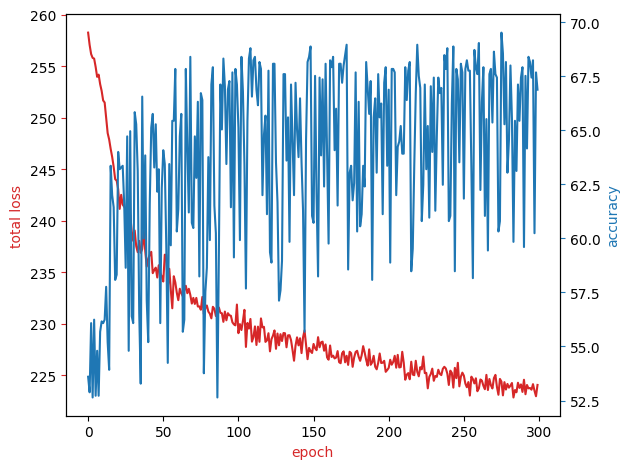

In [147]:
cum_loss_list=load_list_from_file(model_name.replace('_','-') + "-loss.pkl")
acc_epoch=load_list_from_file(model_name.replace('_','-') + "-acc.pkl")
plot(cum_loss_list,acc_epoch)

Let's load actually load the model into model_lora:


In [148]:
model_lora.load_state_dict(torch.load(model_name.replace('_','-') + ".pth", map_location=device))
model_lora.eval()

TextClassifier(
  (embedding): Embedding(400000, 100)
  (fc1): LinearWithLoRA(
    (linear): Linear(in_features=100, out_features=128, bias=True)
    (lora): LoRALayer()
  )
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

And, let's evaluate its performance on the test data.


In [149]:
evaluate(test_dataloader , model_lora, device)


You get a 3% improvement over a model trained from scratch by using LoRA. Note that this occurs despite the fact that the model fine-tuned with LoRA updated less parameters than the model trained from scratch!


The ```model_lora.fc1``` attribute represents ```LinearWithLoRA``` which contains both the standard ```Linear``` layer ``(linear)`` and an additional ```LoRA``` layer ```(lora)``` which represents the ```LoRALayer```.


In [150]:
model_lora.fc1

LinearWithLoRA(
  (linear): Linear(in_features=100, out_features=128, bias=True)
  (lora): LoRALayer()
)

From ```model_lora.fc1.lora```, you can obtain the learnable parameters A and B.  


In [151]:
B=model_lora.fc1.lora.B
print("B",B)
print("\n Number of elements in the tensor B",B.numel())
torch.save(B, 'B.pth')


B Parameter containing:
tensor([[-4.3192e-01, -1.1071e+00,  2.4456e-01, -3.1031e-02, -2.0012e-01,
         -6.7811e-01, -1.3552e-01, -2.7458e-01,  3.2278e-02,  6.7592e-02,
          8.3020e-01,  1.1610e-05, -1.0894e-01,  7.7830e-05, -1.6789e-01,
         -1.3309e-01, -5.1875e-01,  2.1928e-02, -6.5869e-02, -3.5834e-01,
         -2.4473e-02, -1.1260e+00, -8.8752e-02, -7.0861e-03, -1.3263e-02,
          0.0000e+00, -6.9039e-01, -8.6471e-02, -3.9146e-01, -2.2644e-01,
         -8.7611e-01, -7.9929e-01,  0.0000e+00,  3.9646e-01,  5.2164e-01,
         -4.2730e-01,  2.3550e-01,  4.0447e-02,  2.3289e-01, -4.5217e-01,
          1.7721e-03, -4.7263e-01, -2.4343e-01,  6.3737e-01,  0.0000e+00,
          2.6904e-03, -7.8828e-01,  2.2559e-02, -4.3776e-02,  3.0909e-01,
         -1.6914e-01, -2.0294e-01, -4.2175e-01,  7.8840e-01, -3.1771e-01,
         -2.0639e-01,  1.1487e-02, -5.7238e-01,  1.4071e-01, -2.8561e-01,
          1.1753e-01, -1.6501e-04, -4.5406e-01,  0.0000e+00,  6.4464e-05,
         -4.45

In [152]:
A=model_lora.fc1.lora.A
print("A",A)
print("\n Number of elements in the tensor A",A.numel())
torch.save(A, 'A.pth')

A Parameter containing:
tensor([[ 3.2952e-01,  9.3019e-01],
        [ 2.3904e+00, -5.1022e+00],
        [-2.4573e-01,  2.4733e+00],
        [ 5.8014e-01,  3.9014e-01],
        [ 1.6970e+00, -2.4614e+00],
        [-1.2420e+00,  8.3014e-01],
        [-2.0468e+00,  1.1629e+00],
        [-5.9361e-01,  1.8099e-01],
        [ 9.2466e-02,  1.1583e-01],
        [-2.0841e-02,  1.5550e+00],
        [ 1.3028e+00, -9.8381e-01],
        [ 1.4320e+00, -3.3497e+00],
        [-1.1637e+00,  1.9436e+00],
        [ 2.4898e-01, -1.1353e+00],
        [ 2.4423e+00,  1.0154e+00],
        [ 2.4881e+00, -4.6765e+00],
        [-1.8985e-01,  1.3426e+00],
        [-1.1730e-01, -2.1925e+00],
        [ 2.0193e+00, -8.5886e-01],
        [-3.1268e+00,  3.5134e+00],
        [ 1.0935e+00, -2.9263e+00],
        [-1.0435e+00,  2.5428e-01],
        [-8.6704e-01,  2.3570e+00],
        [-5.2725e-02, -2.3731e-01],
        [-4.3896e+00,  5.0369e+00],
        [-1.1174e+00,  9.9728e-01],
        [ 4.7710e-01, -1.2162e+00],
    

A and B have approximately 450 parameters. If you were to store the entire linear layer, you would have 12,800 parameters, which is around 28 times more. Remember, this is possibly the simplest model that you can have.


In [153]:

print("\n Number of elements in the tensor A",model_lora.fc1.linear.weight.numel())



 Number of elements in the tensor A 12800


 alfa and the ouput layer  are also saved.


In [154]:
alfa_=model_lora.fc1.lora.alpha
torch.save(alfa_, 'alfa_.pth')
torch.save(model_lora.fc2.state_dict(), 'out_layer.pth')


## Loading the model

The main advantage of LoRA is that for fine-tuning, you only need to save the learnable parameters A and B, alpha, and the output layer in your classification example.


The saved files are converted to tensors and the linear layer, respectively.


In [155]:
A = torch.load('A.pth')
print("A:",A.shape)

A: torch.Size([100, 2])


In [156]:
B = torch.load('B.pth')
print("B:",B.shape)

B: torch.Size([2, 128])


In [157]:
alfa_ = torch.load('alfa_.pth')
alfa_ 


The output layer:


In [158]:
output_layer=nn.Linear(in_features=128, out_features=2, bias=True)
output_layer.load_state_dict(torch.load('out_layer.pth'))

<All keys matched successfully>

The model object is created and the pretrained parameters are loaded:


In [159]:

model_load_lora = TextClassifier(num_classes=4,freeze=False)
model_load_lora.to(device)

urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/uGC04Pom651hQs1XrZ0NsQ/my-model-freeze-false.pth')

stream = io.BytesIO(urlopened.read())
state_dict = torch.load(stream, map_location=device)
model_load_lora.load_state_dict(state_dict)

model_load_lora

TextClassifier(
  (embedding): Embedding(400000, 100)
  (fc1): Linear(in_features=100, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=4, bias=True)
)

The LoRA layer object is added to the original hidden layer.


In [160]:
model_load_lora.fc1=LinearWithLoRA(model_load_lora.fc1,rank=2, alpha=0.1)
model_load_lora.fc2=nn.Linear(in_features=128, out_features=2, bias=True).to(device)

The parameters from fine-tuning are added.


In [161]:
model_load_lora.fc1.lora.A=A
model_load_lora.fc1.lora.B=B
model_load_lora.fc1.lora.alpha=alfa_ 
model_load_lora.fc2=output_layer

In [162]:
model_load_lora.to(device)
model_load_lora.eval()


TextClassifier(
  (embedding): Embedding(400000, 100)
  (fc1): LinearWithLoRA(
    (linear): Linear(in_features=100, out_features=128, bias=True)
    (lora): LoRALayer()
  )
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

In [163]:
evaluate(test_dataloader , model_load_lora, device)

This confirms that the model loaded correctly. You still get a 3% improvement in accuracy!


Finally, the following shows how you can make a prediction on the following article using the function **`predict`**:


In [164]:
article="""This was a lacklustre movie with very little going for it. I was not impressed."""

This markdown content generates a styled box with light gray background and padding. It contains an `<h3>` header displaying the content of the `article` variable, and an `<h4>` header indicating the predicted category of the news article which is provided by the `result` variable. The placeholders `{article}` and `{result}` will be dynamically replaced with actual values when this markdown is rendered.


In [165]:
result = predict(article, model_load_lora, text_pipeline)

markdown_content = f'''
<div style="background-color: lightgray; padding: 10px;">
    <h3>{article}</h3>
    <h4>The category of the news article: {result}</h4>
</div>
'''

md(markdown_content)


<div style="background-color: lightgray; padding: 10px;">
    <h3>This was a lacklustre movie with very little going for it. I was not impressed.</h3>
    <h4>The category of the news article:  negative review</h4>
</div>


---
## Exercise: Apply LoRA to a different network

The following code defines a neural network called `NNet`. 

`NNet` is a neural network that was originally written to identify hand-written digits from 32x32 images. Your task is to fine-tune this network to perform letter recognition using LoRA by replacing the section labeled `### REPLACE THIS ###` in the code block below. To enhance your understanding, apply LoRA to just the second linear layer, and replace the last layer with a layer that has 26 outputs, one for each letter in the English alphabet.


In [167]:

class NNet(nn.Module):

    def __init__(self):
        super(NNet, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # 5*5 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, input):
        # Convolution layer C1: 1 input image channel, 6 output channels,
        # 5x5 square convolution, it uses RELU activation function, and
        # outputs a Tensor with size (N, 6, 28, 28), where N is the size of the batch
        c1 = F.relu(self.conv1(input))
        # Subsampling layer S2: 2x2 grid, purely functional,
        # this layer does not have any parameter, and outputs a (N, 6, 14, 14) Tensor
        s2 = F.max_pool2d(c1, (2, 2))
        # Convolution layer C3: 6 input channels, 16 output channels,
        # 5x5 square convolution, it uses RELU activation function, and
        # outputs a (N, 16, 10, 10) Tensor
        c3 = F.relu(self.conv2(s2))
        # Subsampling layer S4: 2x2 grid, purely functional,
        # this layer does not have any parameter, and outputs a (N, 16, 5, 5) Tensor
        s4 = F.max_pool2d(c3, 2)
        # Flatten operation: purely functional, outputs a (N, 400) Tensor
        s4 = torch.flatten(s4, 1)
        # Fully connected layer F5: (N, 400) Tensor input,
        # and outputs a (N, 120) Tensor, it uses RELU activation function
        f5 = F.relu(self.fc1(s4))
        # Fully connected layer F6: (N, 120) Tensor input,
        # and outputs a (N, 84) Tensor, it uses RELU activation function
        f6 = F.relu(self.fc2(f5))
        # Gaussian layer OUTPUT: (N, 84) Tensor input, and
        # outputs a (N, 10) Tensor
        output = self.fc3(f6)
        return output

model_exercise = NNet()
model_exercise.to(device)

print('This is what the model looked like before applying LoRA:')
print(model_exercise)
print("\n###############\n")

# Freeze all parameters:
for parm in model_exercise.parameters():
    parm.requires_grad=False

# Change final layer for one with 26 outputs:
model_exercise.fc3=nn.Linear(in_features=84, out_features=26, bias=True).to(device)

# Apply LoRA to the second linear layer
model_exercise.fc2=LinearWithLoRA(model_exercise.fc2,rank=2, alpha=0.1).to(device)

print('This is what the model looked like after applying LoRA:')
print(model_exercise)

This is what the model looked like before applying LoRA:
NNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

###############

This is what the model looked like after applying LoRA:
NNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): LinearWithLoRA(
    (linear): Linear(in_features=120, out_features=84, bias=True)
    (lora): LoRALayer()
  )
  (fc3): Linear(in_features=84, out_features=26, bias=True)
)


<details>
    <summary>Click here for the solution</summary>

```python
class NNet(nn.Module):

    def __init__(self):
        super(NNet, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # 5*5 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, input):
        # Convolution layer C1: 1 input image channel, 6 output channels,
        # 5x5 square convolution, it uses RELU activation function, and
        # outputs a Tensor with size (N, 6, 28, 28), where N is the size of the batch
        c1 = F.relu(self.conv1(input))
        # Subsampling layer S2: 2x2 grid, purely functional,
        # this layer does not have any parameter, and outputs a (N, 6, 14, 14) Tensor
        s2 = F.max_pool2d(c1, (2, 2))
        # Convolution layer C3: 6 input channels, 16 output channels,
        # 5x5 square convolution, it uses RELU activation function, and
        # outputs a (N, 16, 10, 10) Tensor
        c3 = F.relu(self.conv2(s2))
        # Subsampling layer S4: 2x2 grid, purely functional,
        # this layer does not have any parameter, and outputs a (N, 16, 5, 5) Tensor
        s4 = F.max_pool2d(c3, 2)
        # Flatten operation: purely functional, outputs a (N, 400) Tensor
        s4 = torch.flatten(s4, 1)
        # Fully connected layer F5: (N, 400) Tensor input,
        # and outputs a (N, 120) Tensor, it uses RELU activation function
        f5 = F.relu(self.fc1(s4))
        # Fully connected layer F6: (N, 120) Tensor input,
        # and outputs a (N, 84) Tensor, it uses RELU activation function
        f6 = F.relu(self.fc2(f5))
        # Gaussian layer OUTPUT: (N, 84) Tensor input, and
        # outputs a (N, 10) Tensor
        output = self.fc3(f6)
        return output

model_exercise = NNet()
model_exercise.to(device)

print('This is what the model looked like before applying LoRA:')
print(model_exercise)
print("\n###############\n")

# Freeze all parameters:
for parm in model_exercise.parameters():
    parm.requires_grad=False

# Change final layer for one with 26 outputs:
model_exercise.fc3=nn.Linear(in_features=84, out_features=26, bias=True).to(device)

# Apply LoRA to the second linear layer
model_exercise.fc2=LinearWithLoRA(model_exercise.fc2,rank=2, alpha=0.1).to(device)

print('This is what the model looked like after applying LoRA:')
print(model_exercise)
```

</details>


---


## Congratulations! You have completed the lab


## Authors


[Joseph Santarcangelo](https://author.skills.network/instructors/joseph_santarcangelo) has a Ph.D. in Electrical Engineering, his research focused on using machine learning, signal processing, and computer vision to determine how videos impact human cognition. Joseph has been working for IBM since he completed his Ph.D.


[Wojciech "Victor" Fulmyk](https://www.linkedin.com/in/wfulmyk) is a Data Scientist at IBM, and a PhD Candidate in economics at the University of Calgary.


[Ashutosh Sagar](https://www.linkedin.com/in/ashutoshsagar/) is completing his MS in CS from Dalhousie University. He has previous experience working with Natural Language Processing and as a Data Scientist.


## References

[Finetuning with LoRA -- A Hands-On Example](https://lightning.ai/lightning-ai/studios/code-lora-from-scratch)

[TEXT CLASSIFICATION WITH THE TORCHTEXT LIBRARY](https://pytorch.org/tutorials/beginner/text_sentiment_ngrams_tutorial.html)




```{## Change Log}
```


```{|Date (YYYY-MM-DD)|Version|Changed By|Change Description||-|-|-|-||2023-07-27|0.1|Joseph|Created Lab||2024-06-04|1.0|wfulmyk|First release|}
```


© Copyright IBM Corporation. All rights reserved.
